# EXPERIMENTATION MACHINE LEARNING

    --LOAD/SPLIT


In [89]:
# import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import shap

from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    cross_validate, GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    recall_score, precision_score
)

df = pd.read_csv("save_final.csv")
# 1️⃣ Séparation X / y + split TRAIN / TEST (gelé)

# Variable cible
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

# Split stratifié ( 80% train, 20% test )
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

numeric_features = X.columns.tolist()


##    --Preprocess+imputation



    


In [90]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)
    ]
)


BASELINE 


In [91]:
baseline_models = {
    "log_reg": LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ),
    "random_forest": RandomForestClassifier(
        random_state=42,
        class_weight="balanced"
    ),
    "xgboost": XGBClassifier(
        random_state=42,
        eval_metric="logloss",
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    )
}

baseline_results = {}

for name, clf in baseline_models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", clf)
    ])

    pipe.fit(X_train, y_train)

    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    baseline_results[name] = {
        "recall": recall_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "pr_auc": average_precision_score(y_test, y_proba)
    }


## GRIDSEARCH CV 

In [92]:
cv_inner = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

#  Logistic Regression

pipe_lr = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

param_grid_lr = {
    "model__C": [0.01, 0.1, 1, 10]
}

grid_lr = GridSearchCV(
    pipe_lr,
    param_grid_lr,
    scoring="recall",
    cv=cv_inner,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)
best_lr = grid_lr.best_estimator_


# Random Forest

pipe_rf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        random_state=42,
        class_weight="balanced"
    ))
])

param_grid_rf = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_leaf": [1, 5]
}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    scoring="recall",
    cv=cv_inner,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

# XGBoost

pipe_xgb = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        random_state=42,
        eval_metric="logloss",
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    ))
])

param_grid_xgb = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [3, 5],
    "model__learning_rate": [0.01, 0.1],
    "model__subsample": [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    pipe_xgb,
    param_grid_xgb,
    scoring="recall",
    cv=cv_inner,
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)
best_xgb = grid_xgb.best_estimator_



cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "roc_auc": "roc_auc",
    "recall": "recall",
    "f1": "f1"
}

models_optimised = {
    "log_reg": best_lr,
    "random_forest": best_rf,
    "xgboost": best_xgb
}
cv_results = {}

for name, clf in models_optimised.items():
    scores = cross_validate(
        clf,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )

    cv_results[name] = {
        metric: scores[f"test_{metric}"].mean()
        for metric in scoring
    }






## Cross-validation clinique (MODÈLES OPTIMISÉS)

In [93]:
#  Seuil clinique minimum pour le recall
RECALL_MIN = 0.75

#  Sélection des modèles éligibles
eligible = {k: v for k, v in cv_results.items() if v["recall"] >= RECALL_MIN}

if eligible:
    # Choisir le meilleur modèle parmi les éligibles selon le ROC-AUC
    best_model_name = max(eligible, key=lambda k: eligible[k]["roc_auc"])
    print(f"\n✅ Modèle clinique retenu parmi les éligibles (Recall ≥ {RECALL_MIN}): {best_model_name}")
else:
    # Aucun modèle ne respecte le seuil, on prend celui avec le meilleur recall
    best_model_name = max(cv_results, key=lambda k: cv_results[k]["recall"])
    print(f"\n⚠️ Aucun modèle n’atteint Recall ≥ {RECALL_MIN}.")
    print(f"➡️ Modèle avec le meilleur recall sélectionné : {best_model_name}")

#  Affichage complet des métriques du modèle retenu
best_metrics = cv_results[best_model_name]
print("\n=== Détails du modèle retenu ===")
print(f"Nom: {best_model_name}")
print(f"ROC-AUC: {best_metrics['roc_auc']:.3f}")
print(f"Recall: {best_metrics['recall']:.3f}")
print(f"F1-score: {best_metrics['f1']:.3f}")

#  Affichage de tous les modèles éligibles dans un tableau
if eligible:
    import pandas as pd
    df_eligible = pd.DataFrame.from_dict(eligible, orient="index")
    df_eligible = df_eligible.sort_values(by="roc_auc", ascending=False)
    print("\n=== Tableau des modèles éligibles (Recall ≥ seuil) ===")
    print(df_eligible)



✅ Modèle clinique retenu parmi les éligibles (Recall ≥ 0.75): random_forest

=== Détails du modèle retenu ===
Nom: random_forest
ROC-AUC: 0.837
Recall: 0.757
F1-score: 0.704

=== Tableau des modèles éligibles (Recall ≥ seuil) ===
                roc_auc    recall        f1
random_forest  0.836932  0.756811  0.704129
xgboost        0.833048  0.752159  0.681977


## Sélection clinique du modèle

In [94]:
RECALL_MIN = 0.75

eligible = {k: v for k, v in cv_results.items() if v["recall"] >= RECALL_MIN}

if eligible:
    best_model_name = max(eligible, key=lambda k: eligible[k]["roc_auc"])
else:
    best_model_name = max(cv_results, key=lambda k: cv_results[k]["recall"])

print("\nModèle clinique retenu :", best_model_name)



Modèle clinique retenu : random_forest


# Entraînement final sur TRAIN

In [95]:
best_model = models_optimised[best_model_name]
best_model.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sparse ma

# Évaluation sur TEST

In [96]:
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("\n=== Évaluation TEST ===")
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC:", average_precision_score(y_test, y_proba))



=== Évaluation TEST ===
Confusion matrix:
 [[73 27]
 [15 39]]
              precision    recall  f1-score   support

           0       0.83      0.73      0.78       100
           1       0.59      0.72      0.65        54

    accuracy                           0.73       154
   macro avg       0.71      0.73      0.71       154
weighted avg       0.75      0.73      0.73       154

ROC-AUC: 0.8198148148148148
PR-AUC: 0.6897530464875506


Optimisation du seuil clinique

In [97]:
def find_optimal_threshold(y_true, y_proba, min_precision=0.30):
    thresholds = np.linspace(0.01, 0.99, 99)
    best_thr, best_rec = None, 0

    for thr in thresholds:
        y_pred = (y_proba >= thr).astype(int)
        rec = recall_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)

        if prec >= min_precision and rec > best_rec:
            best_rec = rec
            best_thr = thr

    return best_thr, best_rec

best_thr, best_rec = find_optimal_threshold(y_test, y_proba)


# Courbes ROC & PR

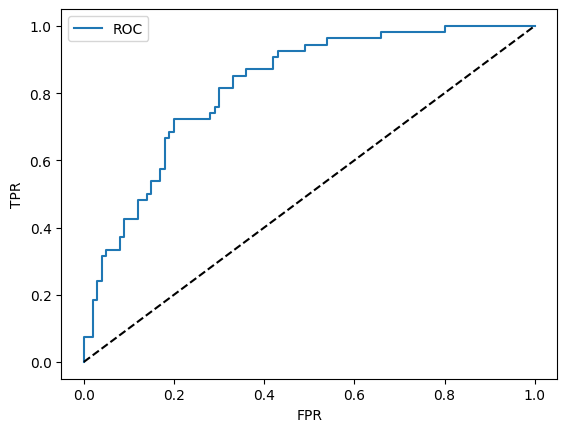

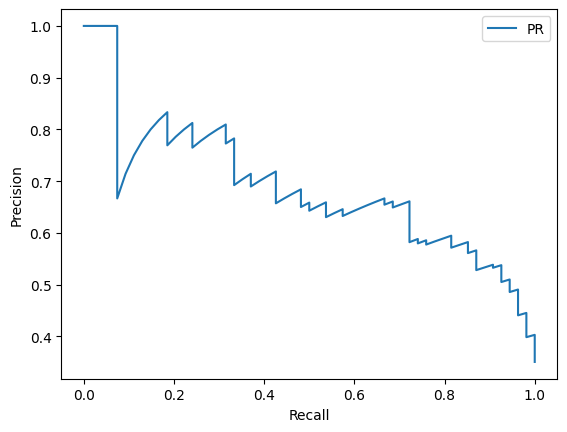

In [98]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
prec, rec, _ = precision_recall_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label="ROC")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

plt.figure()
plt.plot(rec, prec, label="PR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


Decision Curve Analysis (bénéfice clinique)

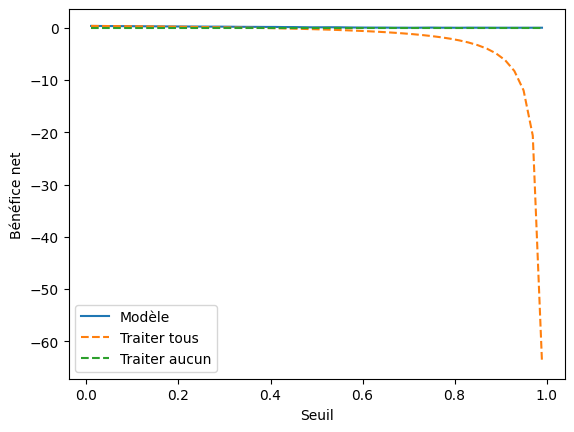

In [99]:
def decision_curve(y_true, y_proba):
    thresholds = np.linspace(0.01, 0.99, 50)
    net_benefit = []
    N = len(y_true)

    for thr in thresholds:
        y_pred = (y_proba >= thr).astype(int)
        TP = np.sum((y_pred == 1) & (y_true == 1))
        FP = np.sum((y_pred == 1) & (y_true == 0))
        nb = (TP / N) - (FP / N) * (thr / (1 - thr))
        net_benefit.append(nb)

    return thresholds, net_benefit

thr, nb_model = decision_curve(y_test, y_proba)
_, nb_all = decision_curve(y_test, np.ones_like(y_test))
_, nb_none = decision_curve(y_test, np.zeros_like(y_test))

plt.figure()
plt.plot(thr, nb_model, label="Modèle")
plt.plot(thr, nb_all, "--", label="Traiter tous")
plt.plot(thr, nb_none, "--", label="Traiter aucun")
plt.xlabel("Seuil")
plt.ylabel("Bénéfice net")
plt.legend()
plt.show()


### La Decision Curve Analysis montre que le modèle offre un bénéfice net positif pour une large gamme de seuils de décision, surpassant les stratégies “traiter tous” et “ne traiter aucun”, ce qui indique une réelle utilité clinique du modèle.

## SHAP – interprétabilité/Explicabilité correcte

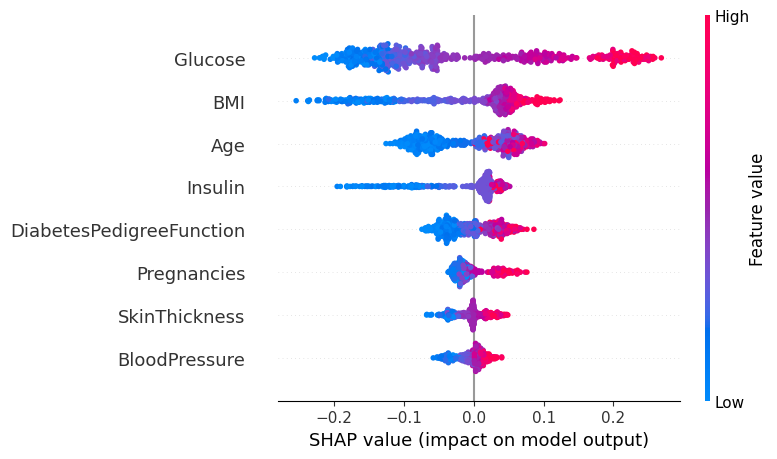

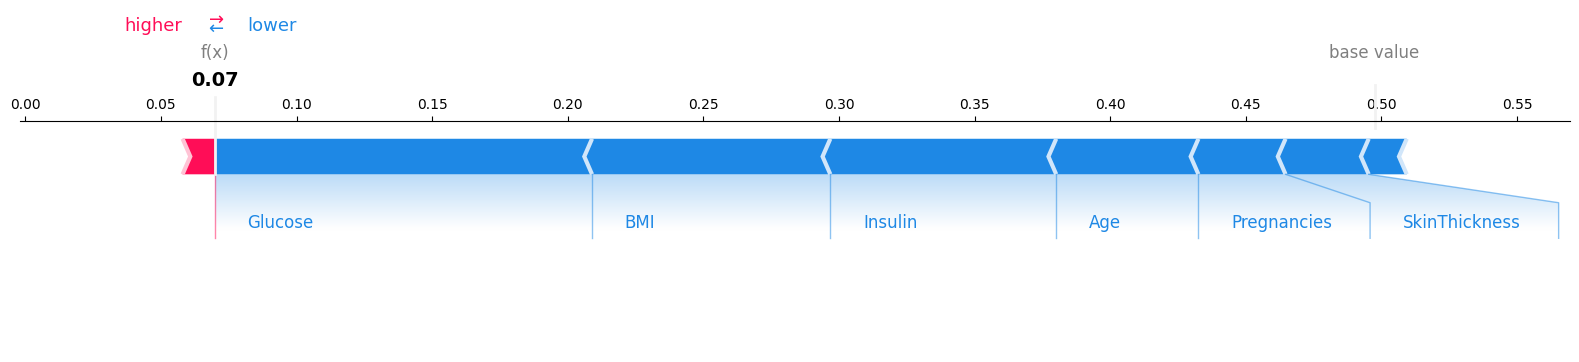

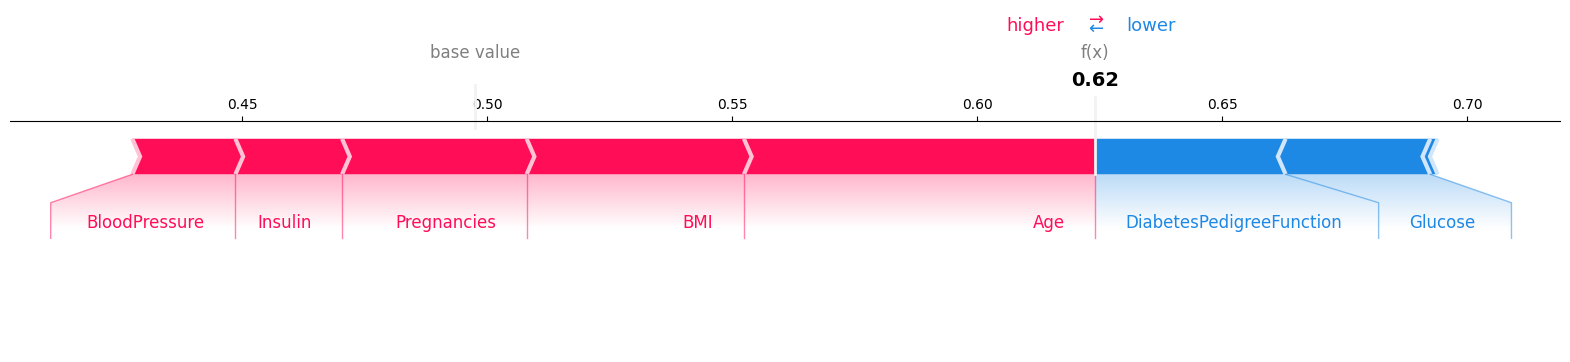

In [100]:
import shap

clf_best = best_model.named_steps["model"]
X_train_transformed = best_model.named_steps["preprocess"].transform(X_train)

explainer = shap.TreeExplainer(clf_best)
shap_values = explainer.shap_values(X_train_transformed)
shap_values_class1 = shap_values[:, :, 1]   # shape : (614, 8)


# Importance globale
shap.summary_plot(
    shap_values_class1,
    X_train_transformed,
    feature_names=numeric_features
)

# Explication pour une patiente
idx = 0

shap.force_plot(
    explainer.expected_value[1],          # classe positive
    shap_values[idx, :, 1],               # shape : (8,)
    feature_names=numeric_features,
    matplotlib=True
)
idx1 = 23
shap.force_plot(
    explainer.expected_value[1],          # classe positive
    shap_values[idx1, :, 1],               # shape : (8,)
    feature_names=numeric_features,
    matplotlib=True
)


## concernant le shap 
L'ordre des lignes (Glucose en haut, puis BMI, Age, Insulin, etc.) indique l’importance globale des features : le Glucose est la variable la plus influente, pour :
* les diabetiques

* La couleur (bleu = valeur faible, rose = valeur élevée) et la position horizontale montrent comment la valeur de la feature affecte la prédiction :

Les points roses pour Glucose sont surtout du côté droit (SHAP > 0) → un glucose élevé augmente la probabilité de la classe « malade / positif ».

Les points bleus pour Glucose sont plus à gauche (SHAP < 0) → un glucose faible diminue cette probabilité.

* Idem pour les autres variables (BMI, Age, Insulin, etc.), on  peux lire de la même façon si des valeurs élevées (rose) poussent en général vers la droite (risque fort ) ou vers la gauche (risque faible).

## Pour un patient(e)

Pour la patiente 0 le model à prédit un très faible risque d'être diabétique (f(x))=0,07 :  un glucose relativement bas et un BMI donné expliquent pourquoi le modèle prévoit un risque faible, même si d’autres variables pourraient aller dans l’autre sens.



Pour la patiente 23 le model une forte probalité pour elle d'être diabétique (f(x)= 0,62) : les features comme : BloodPressure;Insulin;Pregnancies  dont les taux sont relativement haut  expliquent pourquoi le modèle prévoit un risque élevé 62%, pour cette patiente 


SCORING PATIENT

In [101]:
def risk_score(p):
    return int(np.clip(round(p * 100), 0, 100))

def risk_level(p):
    if p < 0.3:
        return "faible"
    elif p < 0.7:
        return "moyen"
    else:
        return "élevé"

sample = X_test.iloc[:5]
sample_proba = best_model.predict_proba(sample)[:, 1]
for i, p in enumerate(sample_proba):
    print(f"Patiente {i}: proba={p:.3f}, score={risk_score(p)}, niveau={risk_level(p)}")



Patiente 0: proba=0.692, score=69, niveau=moyen
Patiente 1: proba=0.233, score=23, niveau=faible
Patiente 2: proba=0.344, score=34, niveau=moyen
Patiente 3: proba=0.419, score=42, niveau=moyen
Patiente 4: proba=0.209, score=21, niveau=faible


# SAUVEGARDE DU MODÈLE FINAL


In [102]:
# bestmodel = modèle retenu (pipeline) ; bestthr = seuil optimal déjà calculé
import joblib

# =========================
# 1️⃣ Calcul des métriques réelles sur le jeu de test
# =========================
from sklearn.metrics import roc_auc_score, recall_score, f1_score

y_test_proba = best_rf.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= 0.5).astype(int)

metrics = {
    "roc_auc": float(roc_auc_score(y_test, y_test_proba)),
    "recall": float(recall_score(y_test, y_test_pred)),
    "f1": float(f1_score(y_test, y_test_pred)),
    "threshold": best_thr
}

model_bundle = {
    "model": best_rf,                 # pipeline complet
    "metrics": metrics,               # métriques réelles
    "feature_names": X.columns.tolist()
}

joblib.dump(model_bundle, "diabetes_risk_model.joblib")

print("✅ Modèle clinique sauvegardé dans diabetes_risk_model.joblib")


✅ Modèle clinique sauvegardé dans diabetes_risk_model.joblib


## comparaison  final (GRIDSEARCH VS BASELINE)

In [103]:
# Évaluation des modèles OPTIMISÉS (GridSearch)
optimized_results = {}

for name, pipe in models_optimised.items():

    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    optimized_results[name] = {
        "recall": recall_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "pr_auc": average_precision_score(y_test, y_proba)
    }


In [104]:
# Entraînement des modèles BASELINE

baseline_models = {
    "log_reg": LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ),
    "random_forest": RandomForestClassifier(
        random_state=42,
        class_weight="balanced"
    ),
    "xgboost": XGBClassifier(
        random_state=42,
        eval_metric="logloss",
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
    )
}

baseline_results = {}

for name, clf in baseline_models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", clf)
    ])

    pipe.fit(X_train, y_train)

    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    baseline_results[name] = {
        "recall": recall_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "pr_auc": average_precision_score(y_test, y_proba)
    }


# Tableau comparatif final (GRIDSEARCH VS BASELINE)

In [105]:
comparison = []

for model in baseline_results.keys():
    comparison.append({
        "model": model,
        "recall_baseline": baseline_results[model]["recall"],
        "recall_optimized": optimized_results[model]["recall"],
        "precision_baseline": baseline_results[model]["precision"],
        "precision_optimized": optimized_results[model]["precision"],
        "roc_auc_baseline": baseline_results[model]["roc_auc"],
        "roc_auc_optimized": optimized_results[model]["roc_auc"],
        "pr_auc_baseline": baseline_results[model]["pr_auc"],
        "pr_auc_optimized": optimized_results[model]["pr_auc"],
    })

comparison_df = pd.DataFrame(comparison)
print(comparison_df)


           model  recall_baseline  recall_optimized  precision_baseline  \
0        log_reg         0.703704          0.666667            0.603175   
1  random_forest         0.592593          0.722222            0.653061   
2        xgboost         0.629630          0.777778            0.641509   

   precision_optimized  roc_auc_baseline  roc_auc_optimized  pr_auc_baseline  \
0             0.571429          0.812593           0.810370         0.672659   
1             0.590909          0.810833           0.819815         0.673123   
2             0.617647          0.809444           0.822778         0.674091   

   pr_auc_optimized  
0          0.665251  
1          0.689753  
2          0.694029  


## On peut conclure que rend le rend  la metric principale  (recall) du modèle choisi ici (random_forest) plus efficient donc optimise notre model 

### API UTLISABLE

In [106]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib

app = FastAPI()

class PatientFeatures(BaseModel):
    Pregnancies: float
    Glucose: float
    BloodPressure: float
    SkinThickness: float
    Insulin: float
    BMI: float
    DiabetesPedigreeFunction: float
    Age: float


model = joblib.load("diabetes_risk_model.joblib")

@app.post("/predict")
def predict_risk(features: PatientFeatures):
    data = [[
        features.Pregnancies,
        features.Glucose,
        features.BloodPressure,
        features.SkinThickness,
        features.Insulin,
        features.BMI,
        features.DiabetesPedigreeFunction,
        features.Age
    ]]
    proba = model.predict_proba(data)[0, 1]
    return {
        "probability": float(proba),
        "score": risk_score(proba),
        "risk_level": risk_level(proba)
    }
